## Задание 1

#### Дано:
Имеется набор данных из системы поискового антиспама.

#### Требуется: 

- Построить классификатор для представленных данных на основе алгоритма Random Forest.
- Написать функцию, подбирающую параметры числа деревьев и процента признаков в деревьях. Построить график.
- Провести сравнение данного метода с известными алгоритмами классификации. 
- Ответить на вопрос: Почему качество классификации для класса spam выше, чем для класса notspam?

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier

import torch
from torch import nn
from torch.utils.data import DataLoader

from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import f1_score
from sklearn.utils.multiclass import unique_labels
from sklearn.decomposition import PCA

from IPython.display import clear_output

In [2]:
train_ = 'spam.train.txt'
test_ = 'spam.test.txt'

features_percent = 0.9
trees = 10

In [3]:
def visualize_data(total_data, train_size, test_size):
    ''' Visualization of total spam data
    :param total_data: Train and test data
    :param train_size: Size of train set
    :param test_size: Size of test set
    :return:
    '''
    pca = PCA(n_components=2)
    projection = pca.fit_transform(total_data)

    fig = plt.figure(figsize=(8, 8))

    plt.rcParams['legend.fontsize'] = 10
    plt.plot(projection[0:train_size, 0], projection[0:train_size, 1],
            'o', markersize=7, color='blue', alpha=0.5, label='Train')
    plt.plot(projection[train_size:train_size+test_size, 0], projection[train_size:train_size+test_size, 1],
            'o', markersize=7, color='red', alpha=0.5, label='Test')
    plt.title('Spam data')
    plt.show()
    
def classification_report(y_true, y_pred):
    ''' Computes clasification metrics

    :param y_true - original class label
    :param y_pred - predicted class label
    :return presicion, recall for each class; micro_f1 measure, macro_f1 measure
    '''
    last_line_heading = 'avg / total'
    final_line_heading = 'final score'

    labels = unique_labels(y_true, y_pred)

    width = len(last_line_heading)
    target_names = ['{0}'.format(l) for l in labels]

    headers = ["precision", "recall", "f1-score", "support"]
    fmt = '%% %ds' % width  # first column: class name
    fmt += '  '
    fmt += ' '.join(['% 9s' for _ in headers])
    fmt += '\n'

    headers = [""] + headers
    report = fmt % tuple(headers)
    report += '\n'

    p, r, f1, s = precision_recall_fscore_support(y_true, y_pred,
                                                  labels=labels,
                                                  average=None)

    f1_macro = 0
    precision_macro = 0
    recall_macro = 0

    for i, label in enumerate(labels):
        values = [target_names[i]]
        f1_macro += f1[i]
        precision_macro += p[i]
        recall_macro += r[i]
        for v in (p[i], r[i], f1[i]):
            values += ["{0:0.5f}".format(v)]
        values += ["{0}".format(s[i])]
        report += fmt % tuple(values)

    report += '\n'

    # compute averages
    values = [last_line_heading]
    for v in (np.average(p, weights=s),
              np.average(r, weights=s),
              np.average(f1, weights=s)):
        values += ["{0:0.5f}".format(v)]
    values += ['{0}'.format(np.sum(s))]
    report += fmt % tuple(values)

    values = [final_line_heading]
    for v in (precision_macro, recall_macro, f1_macro):
        values += ["{0:0.5f}".format(v / labels.size)]
    values += ['{0}'.format(np.sum(s))]
    report += fmt % tuple(values)

    return report

def tune_forest(train_data, test_data, features_percents, num_trees):
    best_f1score = 0
    best_params = [0, 0]
    best_model = None
    results = np.zeros((len(features_percents), len(num_trees)))
    number_of_features = train_data.shape[1]
    for i, feature_percent in enumerate(features_percents):
        for j, trees in enumerate(num_trees):
            use_features_in_tree = int(feature_percent * number_of_features)
            
            # Create the random forest object which will include all the parameters
            # for the fit
            forest = RandomForestClassifier(n_estimators=trees,
                                            max_features=use_features_in_tree)

            # Fit the training data to the Survived labels and create the decision trees
            forest = forest.fit(train_data[:, 1:], train_data[:, 0])
            
            # Take the same decision trees and run it on the test data
            prediction = forest.predict(test_data[:, 1:])
            
            # Check if it's better than previous models
            curr_f1score = f1_score(test_data[:, 0], prediction)

            clear_output(True)
            print('Best params: {}, {} : {}'.format(features_percents[best_params[0]],
                                                    num_trees[best_params[1]],
                                                    np.round(best_f1score, 3)))
            print('Current params: {}, {} : {}'.format(feature_percent,
                                                       trees,
                                                       np.round(curr_f1score, 3)))

            results[i, j] = curr_f1score
            if curr_f1score > best_f1score:
                best_f1score = curr_f1score
                best_model = forest
                best_params = i, j

    return best_model, best_params, results


In [4]:
train_data = np.loadtxt(train_)
test_data  = np.loadtxt(test_)
total_data = np.concatenate(([train_data, test_data]), axis=0)

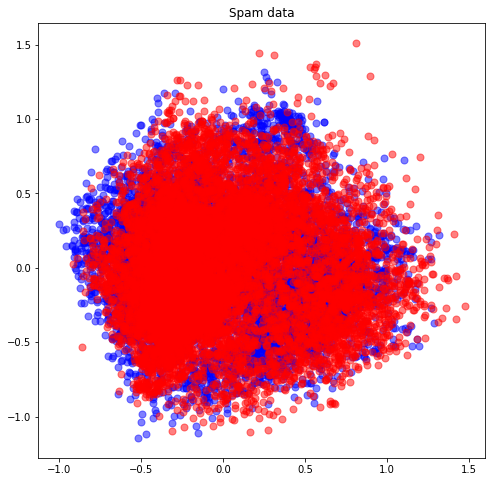

In [5]:
visualize_data(total_data[:, 1:], len(train_data[:, 0]), len(test_data[:, 0]))

In [6]:
features_percents = np.arange(1, 10) / 10
num_trees = [10, 20, 40, 60, 80, 100, 120, 140]

In [7]:
forest, best_params, results = tune_forest(train_data, test_data,
                                           features_percents=features_percents,
                                           num_trees=num_trees)

Best params: 0.3, 140 : 0.967
Current params: 0.9, 140 : 0.948


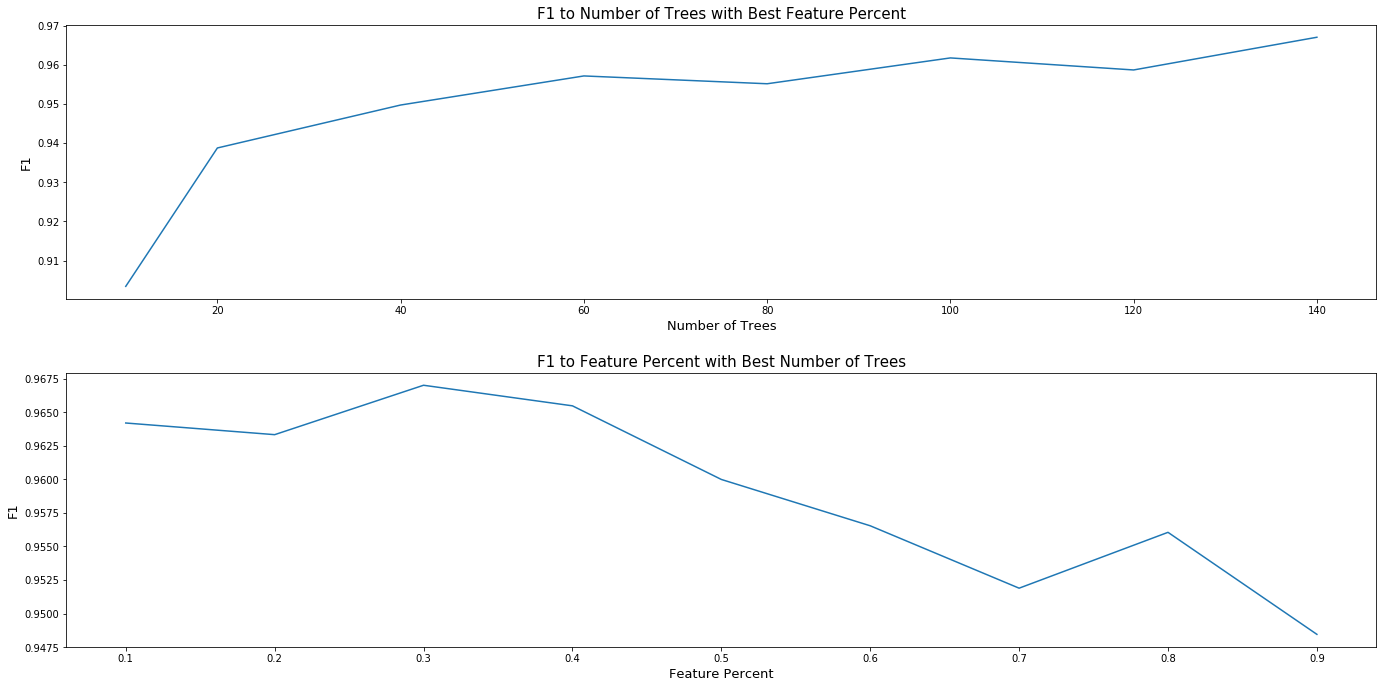

In [8]:
fig = plt.figure(figsize=(20, 10))

ax = plt.subplot(211)
plt.plot(num_trees, results[best_params[0], :])
plt.xlabel('Number of Trees', fontsize=13)
plt.ylabel('F1', fontsize=13)
plt.title('F1 to Number of Trees with Best Feature Percent', fontsize=15)

fig.tight_layout(pad=4.0)

ax = plt.subplot(212)
plt.plot(features_percents, results[:, best_params[1]])
plt.xlabel('Feature Percent', fontsize=13)
plt.ylabel('F1', fontsize=13)
plt.title('F1 to Feature Percent with Best Number of Trees', fontsize=15)

plt.show()

In [9]:
print(classification_report(test_data[:, 0], forest.predict(test_data[:, 1:])))

             precision    recall  f1-score   support

        0.0    0.83042   0.93458   0.87943      2033
        1.0    0.98288   0.95164   0.96701      8023

avg / total    0.95206   0.94819   0.94930     10056
final score    0.90665   0.94311   0.92322     10056



In [10]:
clf = SGDClassifier(max_iter=1000, tol=1e-3)

clf.fit(train_data[:, 1:], train_data[:, 0])

prediction = clf.predict(test_data[:, 1:])

print(classification_report(test_data[:, 0], prediction))

             precision    recall  f1-score   support

        0.0    0.80794   0.92081   0.86069      2033
        1.0    0.97920   0.94453   0.96155      8023

avg / total    0.94457   0.93974   0.94116     10056
final score    0.89357   0.93267   0.91112     10056



In [11]:
clf = SGDClassifier('log', max_iter=1000, tol=1e-3)

clf.fit(train_data[:, 1:], train_data[:, 0])

prediction = clf.predict(test_data[:, 1:])

print(classification_report(test_data[:, 0], prediction))

             precision    recall  f1-score   support

        0.0    0.75469   0.93064   0.83348      2033
        1.0    0.98132   0.92335   0.95145      8023

avg / total    0.93550   0.92482   0.92760     10056
final score    0.86800   0.92699   0.89247     10056



In [12]:
clf = KNeighborsClassifier()

clf.fit(train_data[:, 1:], train_data[:, 0])

prediction = clf.predict(test_data[:, 1:])

print(classification_report(test_data[:, 0], prediction))

             precision    recall  f1-score   support

        0.0    0.80429   0.93999   0.86686      2033
        1.0    0.98411   0.94204   0.96262      8023

avg / total    0.94776   0.94163   0.94326     10056
final score    0.89420   0.94102   0.91474     10056



In [13]:
class LinClassifier(nn.Module):
    def __init__(self, size):
        super().__init__()
        self.linear = nn.Sequential(nn.Linear(size, size // 4),
                                    nn.Sigmoid(),
                                    nn.Linear(size // 4, 2),
                                    nn.LogSoftmax(dim=1))
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x

In [14]:
train_loader = DataLoader([(train_data[i, 1:].astype(np.float32),
                            train_data[i, 0].astype(np.int64))
                           for i in range(train_data.shape[0])],
                          batch_size=50, shuffle=True)

In [15]:
model = LinClassifier(train_data.shape[1] - 1)
loss = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 5

In [16]:
for epoch in range(epochs):
    cnt = 0
    for X, y in train_loader:
        model.zero_grad()
        pred = model(X)
        train_loss = loss(pred, y)
        train_loss.backward()
        optimizer.step()
        cnt += 1
        if cnt % 20 == 0:
            clear_output(True)
            print((np.argmax(pred.data.numpy(), 1) == y.data.numpy()).mean())            

0.94


In [17]:
print(classification_report(test_data[:, 0],
                            np.argmax(model(torch.Tensor(test_data[:, 1:])).data.numpy(), 1)))

             precision    recall  f1-score   support

        0.0    0.70213   0.94147   0.80437      2033
        1.0    0.98377   0.89879   0.93936      8023

avg / total    0.92683   0.90742   0.91207     10056
final score    0.84295   0.92013   0.87187     10056



По итогу экспериментов затюненный Random Forest перебил все остальные алгоритмы классификации при количестве деревьев 140 и проценте признаков 30.

In [20]:
print('Train:\nSpam data: {}\nNonspam data: {}'.format(np.sum(train_data[:, 0] == 1), np.sum(train_data[:, 0] == 0)))
print('Test:\nSpam data: {}\nNonspam data: {}'.format(np.sum(test_data[:, 0] == 1), np.sum(test_data[:, 0] == 0)))

Train:
Spam data: 4123
Nonspam data: 2970
Test:
Spam data: 8023
Nonspam data: 2033


Предсказание для класса Spam лучше, потому что количество прецедентов в обучающей выборке для этого класса больше.